# LSTM Time Series Forecasting
Examples of LSTM time series forecasting. Here are some articles if you are interested in learning more:
* <a href="https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/">How to Develop LSTM Models for Time Series Forecasting</a>

## Imports

In [1]:
from numpy.random import seed
from numpy.random import randn
from numpy import array
from math import sin, fabs, sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, ConvLSTM2D, Flatten
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset Generation
We generate a dataset to be used in the examples

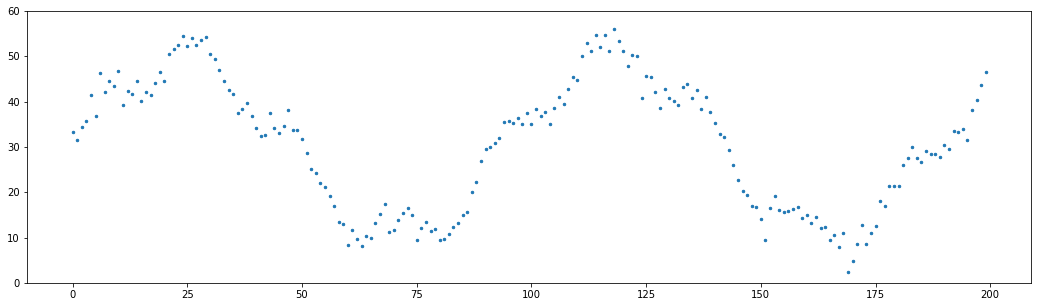

In [2]:
seed(1)
no = 200
# Generate univariate observations
x = []
y = []
for i in range(0,no):
    x.append(sin(i/15) * 20 + sin(i/3.5) * 5 + randn() * 2 + 30)
    y.append(i)

# Plot
plt.figure(figsize=(18,5))
plt.ylim(0,60)
plt.scatter(y,x,s=6)
plt.show()

# Settings
n_steps = 4
xt = x[n_steps:]
yt = y[n_steps:]

## Useful functions

In [3]:
def calc_error(xhat):
    # Calculate error
    mse = 0
    mae = 0
    for v,vhat in zip(xt, xhat):
        mae += fabs(v-vhat)
        mse += (v-vhat)**2
    mae /= len(xt)
    mse /= len(xt)

    print("Result: mae={0:.3f}, mse={1:.3f}, rmse={2:.3f}".format(mae, mse, sqrt(mse)))
    
def plot_result(xhat):
    # Plot
    plt.figure(figsize=(18,5))
    plt.ylim(0,60)
    plt.plot(yt, xhat, c="red")
    plt.scatter(yt, xt, c="blue", s=6)
    plt.show()
    
def predict(model):
    X_test = Xs.reshape((Xs.shape[0], Xs.shape[1], n_features))
    xhat = model.predict(X_test).flatten()
    return xhat

## Data Preparation

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# split into samples
Xs, y = split_sequence(x, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = Xs.reshape((Xs.shape[0], Xs.shape[1], n_features))

## Vanilla LSTM

Result: mae=2.129, mse=7.149, rmse=2.674


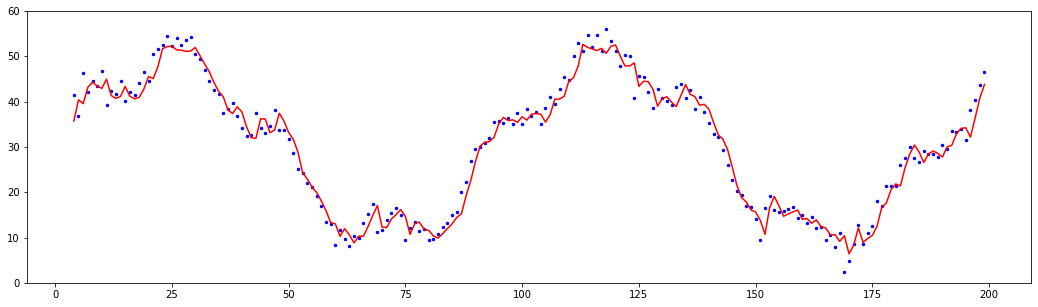

In [5]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# make predictions
xhat = predict(model)
# Show results
calc_error(xhat)
plot_result(xhat)

## Stacked LSTM

Result: mae=2.100, mse=6.976, rmse=2.641


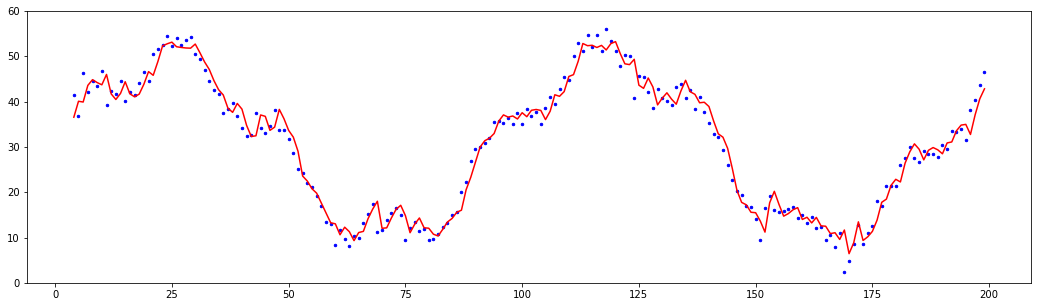

In [6]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# make predictions
xhat = predict(model)
# Show results
calc_error(xhat)
plot_result(xhat)

## ConvLSTM

Result: mae=2.119, mse=7.139, rmse=2.672


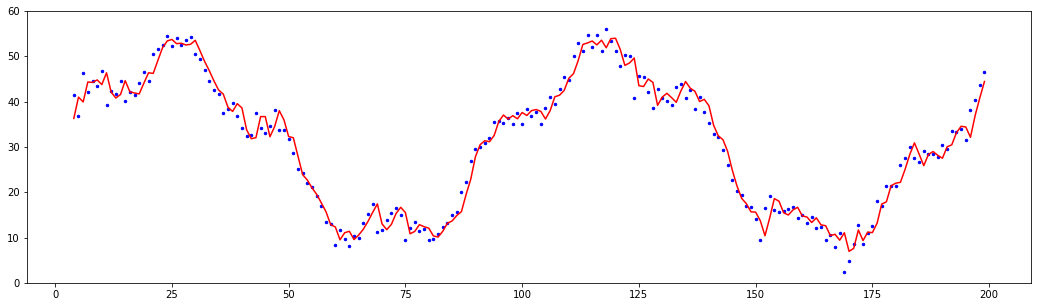

In [7]:
n_seq = 2
n_step = 2
X = Xs.reshape((Xs.shape[0], n_seq, 1, n_step, n_features))

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_step, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# make predictions
xhat = model.predict(X).flatten()
# Show results
calc_error(xhat)
plot_result(xhat)

## Forecasting
Evaluates how well forecasting works.

Result: mae=4.487, mse=25.621, rmse=5.062


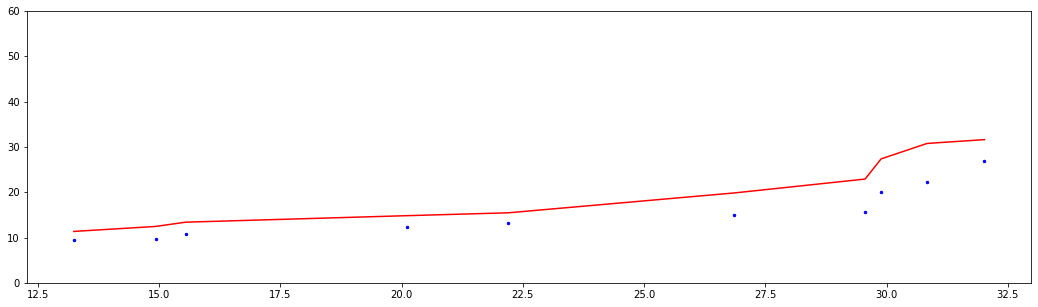

In [8]:
Xs, y = split_sequence(x, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = Xs.reshape((Xs.shape[0], Xs.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

# Number of previous values to include
prev_vals = 50
start = 80
# Number of forecasts to evaluate
no_f = 10

# Forecasts
xhat = []
# Metrics
mae = 0
mse = 0

# Iterate over number of forecasts
for i in range(0, no_f):
    # Cut out input
    Xn = X[start+i-1:start+i]
    
    # Make a one-step forecast
    fval = model.predict(Xn).flatten()[0]
    xhat.append(fval)
    # Actual value
    aval = x[start+i]
    
    # Metrics
    mae += fabs(fval-aval)
    mse += (fval-aval)**2
    
# Metrics
mae /= no_f
mse /= no_f

print("Result: mae={0:.3f}, mse={1:.3f}, rmse={2:.3f}".format(mae, mse, sqrt(mse)))

# Plot
plt.figure(figsize=(18,5))
plt.ylim(0,60)
plt.plot(y[start:start+no_f], xhat, c="red")
plt.scatter(y[start:start+no_f], x[start:start+no_f], c="blue", s=6)
plt.show()